In [5]:
# Import standard libraries 
import warnings
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import datasets
import random 
import numpy.random as rand
from random import randrange
from scipy.stats import bernoulli, binom
import seaborn as sns
from scipy import stats as stat
import pylab 
from tueplots import axes, bundles , figsizes, fonts,fontsizes
from matplotlib.lines import Line2D


# 1 - Load data sets 

In [6]:
'''
Load all datasets.
nsw = Male sub sample of treated and control units as used by Lalonde (1986).
nswre74  = Further subsample extracted by Dehejia and Wahba (1999) which includes information on earnings in 1974 (re74)

cps1 = full Current Population Survey dataset
cps2 , cps3 and cps4 are further subsamples exctracted by lalonde to with distributions which better match the nsw treated group.

psid1 = full Panel Study of Income Dynamics dataset
psid2,psid3,psid4 are again subsamples extracted by Lalonde 

'''
# experimental data 

nsw = pd.read_stata("/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/nsw.dta")
nsw.drop('data_id', axis=1, inplace=True)
nswre74_control = pd.read_excel('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/nswre74_control.xls')
nswre74_treated = pd.read_excel('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/nswre74_treated.xlsx')
nswre74 = pd.concat([nswre74_control,nswre74_treated],axis=0,ignore_index=True) #Combine treatment into a single control as pandas dataframe

# non experimental data (cps)

cps = pd.read_stata("/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/cps_controls.dta")
cps.drop('data_id', axis=1, inplace=True)

#cps['treat'] == 0 # created treated column
#load non experimental data (psid)

psid = pd.read_stata("/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/psid_controls.dta")
psid.drop('data_id', axis=1, inplace=True)

# reset indexes

nsw = nsw.reset_index(drop=True)
nswre74 = nswre74.reset_index(drop=True)
cps = cps.reset_index(drop=True)
psid = psid.reset_index(drop=True)

# Exploratory Analysis

### Plotting functions

In [7]:
#### Q-Q plot
def plot_data(df,feature,title):
    # neat plot 
    plt.rcParams.update({"figure.dpi": 150}) 
    plt.rcParams.update(bundles.neurips2022())
    plt.rcParams.update(fonts.neurips2022())
    plt.rcParams.update(axes.tick_direction( y="in"))
    plt.rcParams.update(axes.color(base="black"))
    plt.rcParams.update(figsizes.neurips2022(nrows=1, ncols=2))
    #historigram
    plt.figure(figsize=(4,3))
    plt.subplot(1,2,1)
    plt.grid(color='white', axis='y')
    plt.grid(color='white', axis='x')
    plt.tick_params(right='on')
    plt.tick_params(left='on')
    plt.tick_params(top='on')
    plt.title("Histogram")
    df[feature].hist(bins=20)
    #qq plot 
    plt.subplot(1,2,2)
    plt.grid(color='white', axis='y')
    plt.grid(color='white', axis='x')
    stat.probplot(df[feature],dist='norm',plot=pylab)
    plt.suptitle(title)
    plt.show()

In [8]:
import matplotlib.gridspec as gridspec

class SeabornFigToGrid():

    def __init__(self, seaborngrid, fig,  subplot_spec):
        self.fig = fig
        self.sg = seaborngrid
        self.subplot = subplot_spec
        if isinstance(self.sg, sns.axisgrid.FacetGrid) or \
            isinstance(self.sg, sns.axisgrid.PairGrid):
            self._movegrid()
        elif isinstance(self.sg, sns.axisgrid.JointGrid):
            self._movejointgrid()
        self._finalize()

    def _movegrid(self):
        """ Move PairGrid or Facetgrid """
        self._resize()
        n = self.sg.axes.shape[0]
        m = self.sg.axes.shape[1]
        self.subgrid = gridspec.GridSpecFromSubplotSpec(n,m, subplot_spec=self.subplot)
        for i in range(n):
            for j in range(m):
                self._moveaxes(self.sg.axes[i,j], self.subgrid[i,j])

    def _movejointgrid(self):
        """ Move Jointgrid """
        h= self.sg.ax_joint.get_position().height
        h2= self.sg.ax_marg_x.get_position().height
        r = int(np.round(h/h2))
        self._resize()
        self.subgrid = gridspec.GridSpecFromSubplotSpec(r+1,r+1, subplot_spec=self.subplot)

        self._moveaxes(self.sg.ax_joint, self.subgrid[1:, :-1])
        self._moveaxes(self.sg.ax_marg_x, self.subgrid[0, :-1])
        self._moveaxes(self.sg.ax_marg_y, self.subgrid[1:, -1])

    def _moveaxes(self, ax, gs):
        #https://stackoverflow.com/a/46906599/4124317
        ax.remove()
        ax.figure=self.fig
        self.fig.axes.append(ax)
        self.fig.add_axes(ax)
        ax._subplotspec = gs
        ax.set_position(gs.get_position(self.fig))
        ax.set_subplotspec(gs)

    def _finalize(self):
        plt.close(self.sg.fig)
        self.fig.canvas.mpl_connect("resize_event", self._resize)
        self.fig.canvas.draw()

    def _resize(self, evt=None):
        self.sg.fig.set_size_inches(self.fig.get_size_inches())

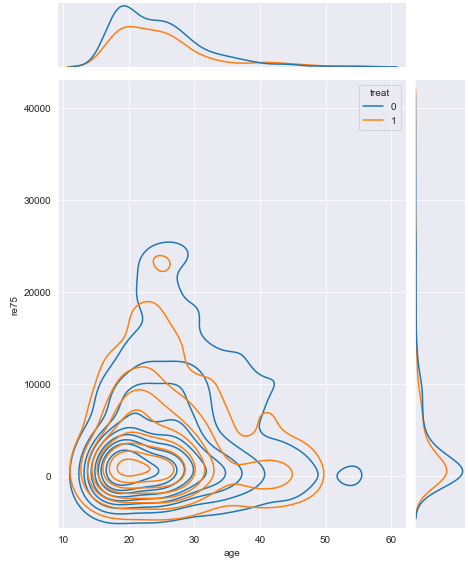

In [9]:
sns.set_style('darkgrid')

plot_kind = 'kde'
hue = 'treat'


g0 = sns.jointplot(data= nsw,x="age",y="re75", hue= hue, kind=plot_kind)
#g1 = sns.jointplot(data= nsw,x="age",y="re78", hue= hue, kind=plot_kind)
#g3 = sns.jointplot(data= nsw,x="education",y="re78", hue= hue, kind=plot_kind)
##g2 = sns.jointplot(data= nsw,x="education",y="re75", hue= hue, kind=plot_kind)


gs = gridspec.GridSpec(1,4)
fig = plt.figure(figsize=(24,8))

mg0 = SeabornFigToGrid(g0, fig, gs[0])
#mg1 = SeabornFigToGrid(g1, fig, gs[1])
#mg2 = SeabornFigToGrid(g2, fig, gs[2])
#mg3 = SeabornFigToGrid(g3, fig, gs[3])


gs.tight_layout(fig)

In [10]:
mg0 = SeabornFigToGrid(g0, fig, gs[0])

In [11]:
nsw[nsw['treat']==1].describe()

,treat,age,education,black,hispanic,married,nodegree,re75,re78
count,297.0,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000
mean,1.0,24.626263,10.380471,0.801347,0.094276,0.168350,0.730640,3066.097656,5976.353516
std,0.0,6.686391,1.817712,0.399660,0.292706,0.374808,0.444376,4874.889160,6923.800293
min,1.0,17.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.0,20.000000,9.000000,1.000000,0.000000,0.000000,0.000000,0.000000,549.298401
50%,1.0,23.000000,11.000000,1.000000,0.000000,0.000000,1.000000,1117.438965,4232.309082
75%,1.0,27.000000,12.000000,1.000000,0.000000,0.000000,1.000000,4310.455078,9381.294922
max,1.0,49.000000,16.000000,1.000000,1.000000,1.000000,1.000000,37431.660156,60307.929688


In [12]:
nsw[nsw['treat']==0].describe()

,treat,age,education,black,hispanic,married,nodegree,re75,re78
count,425.0,425.000000,425.000000,425.000000,425.000000,425.000000,425.000000,425.000000,425.000000
mean,0.0,24.447059,10.188235,0.800000,0.112941,0.157647,0.814118,3026.682861,5090.047852
std,0.0,6.590276,1.618686,0.400471,0.316894,0.364839,0.389470,5201.246582,5718.085938
min,0.0,17.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.0,19.000000,9.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,0.0,23.000000,10.000000,1.000000,0.000000,0.000000,1.000000,823.254395,3746.700928
75%,0.0,28.000000,11.000000,1.000000,0.000000,0.000000,1.000000,3649.769043,8329.823242
max,0.0,55.000000,14.000000,1.000000,1.000000,1.000000,1.000000,36941.269531,39483.531250


In [13]:
nswre74[nswre74['treat']==1].describe()

,treat,age,education,black,hispanic,married,nodegree,re74,re75,re78
count,185.0,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000
mean,1.0,25.816216,10.345946,0.843243,0.059459,0.189189,0.708108,2095.573689,1532.055314,6349.143530
std,0.0,7.155019,2.010650,0.364558,0.237124,0.392722,0.455867,4886.620353,3219.250870,7867.402218
min,1.0,17.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.0,20.000000,9.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,485.229800
50%,1.0,25.000000,11.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,4232.309000
75%,1.0,29.000000,12.000000,1.000000,0.000000,0.000000,1.000000,1291.468000,1817.284000,9642.999000
max,1.0,48.000000,16.000000,1.000000,1.000000,1.000000,1.000000,35040.070000,25142.240000,60307.930000


In [14]:
nswre74[nswre74['treat']==1].describe()

,treat,age,education,black,hispanic,married,nodegree,re74,re75,re78
count,185.0,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000
mean,1.0,25.816216,10.345946,0.843243,0.059459,0.189189,0.708108,2095.573689,1532.055314,6349.143530
std,0.0,7.155019,2.010650,0.364558,0.237124,0.392722,0.455867,4886.620353,3219.250870,7867.402218
min,1.0,17.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.0,20.000000,9.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,485.229800
50%,1.0,25.000000,11.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,4232.309000
75%,1.0,29.000000,12.000000,1.000000,0.000000,0.000000,1.000000,1291.468000,1817.284000,9642.999000
max,1.0,48.000000,16.000000,1.000000,1.000000,1.000000,1.000000,35040.070000,25142.240000,60307.930000


In [15]:
nswre74[nswre74['treat']==0].describe()

,treat,age,education,black,hispanic,married,nodegree,re74,re75,re78
count,260.0,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000
mean,0.0,25.053846,10.088462,0.826923,0.107692,0.153846,0.834615,2107.026658,1266.909002,4554.801126
std,0.0,7.057745,1.614325,0.379043,0.310589,0.361497,0.372244,5687.905694,3102.982044,5483.835991
min,0.0,17.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.0,19.000000,9.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
50%,0.0,24.000000,10.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,3138.795500
75%,0.0,28.000000,11.000000,1.000000,0.000000,0.000000,1.000000,139.424700,650.096475,7288.420000
max,0.0,55.000000,14.000000,1.000000,1.000000,1.000000,1.000000,39570.680000,23031.980000,39483.530000


In [16]:
cps.describe()

,treat,age,education,black,hispanic,married,nodegree,re74,re75,re78
count,15992.0,15992.000000,15992.000000,15992.000000,15992.000000,15992.000000,15992.000000,15992.000000,15992.000000,15992.000000
mean,0.0,33.225239,12.027514,0.073537,0.072036,0.711731,0.295835,14016.423828,13650.932617,14847.295898
std,0.0,11.045195,2.870768,0.261036,0.258558,0.452951,0.456400,9569.904297,9270.392578,9647.392578
min,0.0,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.0,24.000000,11.000000,0.000000,0.000000,0.000000,0.000000,4403.452393,4398.823242,5669.298096
50%,0.0,31.000000,12.000000,0.000000,0.000000,1.000000,0.000000,15123.580078,14557.110352,16421.974609
75%,0.0,42.000000,13.000000,0.000000,0.000000,1.000000,1.000000,23584.179688,22923.736816,25564.669922
max,0.0,55.000000,18.000000,1.000000,1.000000,1.000000,1.000000,25862.320312,25243.550781,25564.669922


In [17]:
psid.describe()

,treat,age,education,black,hispanic,married,nodegree,re74,re75,re78
count,2490.0,2490.000000,2490.000000,2490.000000,2490.000000,2490.000000,2490.000000,2490.000000,2490.000000,2490.000000
mean,0.0,34.850601,12.116867,0.250602,0.032530,0.866265,0.305221,19428.792969,19063.324219,21553.917969
std,0.0,10.440774,3.082437,0.433448,0.177438,0.340434,0.460595,13406.878906,13596.924805,15555.367188
min,0.0,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.0,26.000000,11.000000,0.000000,0.000000,1.000000,0.000000,10775.966797,9846.774414,11526.266602
50%,0.0,33.000000,12.000000,0.000000,0.000000,1.000000,0.000000,18417.107422,17903.226562,20688.171875
75%,0.0,44.000000,14.000000,1.000000,0.000000,1.000000,1.000000,26450.101562,26496.773438,29554.531250
max,0.0,55.000000,17.000000,1.000000,1.000000,1.000000,1.000000,137148.687500,156653.234375,121173.578125


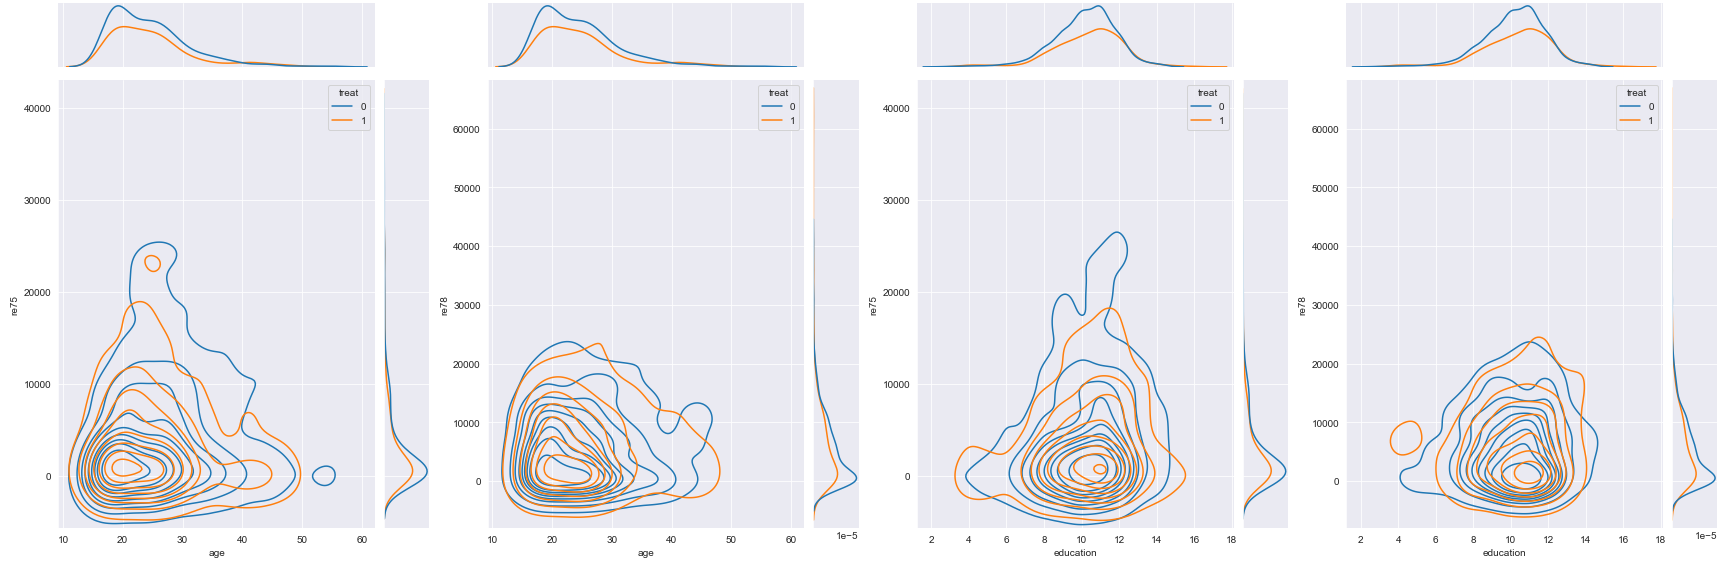

In [18]:
# Joint distributions
sns.set_style('darkgrid')

plot_kind = 'kde'
hue = 'treat'


g0 = sns.jointplot(data= nsw,x="age",y="re75", hue= hue, kind=plot_kind)
g1 = sns.jointplot(data= nsw,x="age",y="re78", hue= hue, kind=plot_kind)
g2 = sns.jointplot(data= nsw,x="education",y="re75", hue= hue, kind=plot_kind)
g3 = sns.jointplot(data= nsw,x="education",y="re78", hue= hue, kind=plot_kind)


fig = plt.figure(figsize=(24,8))
gs = gridspec.GridSpec(1,4)

mg0 = SeabornFigToGrid(g0, fig, gs[0])
mg1 = SeabornFigToGrid(g1, fig, gs[1])
mg2 = SeabornFigToGrid(g2, fig, gs[2])
mg3 = SeabornFigToGrid(g3, fig, gs[3])


gs.tight_layout(fig)


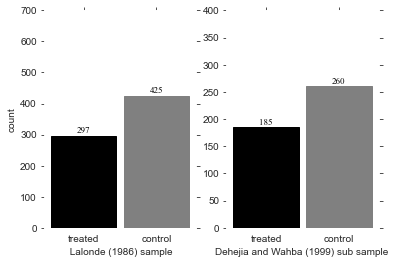

In [19]:
# Plot the balance of classes in the datasets 

# Lalonde sample 
nswTreated = nsw[nsw['treat']==1]
nswControl = nsw[nsw['treat']==0]
nsw_heights = [len(nswTreated),len(nswControl)]

# Dehejia & Wahba subsample 

nswRe74_Treated = nswre74[nswre74['treat']==1]
nswRe74_Control = nswre74[nswre74['treat']==0]
nswRe74_heights = [len(nswRe74_Treated),len(nswRe74_Control),]

# Update plot paramaters 
fig, ax = plt.subplots(nrows=1, ncols=2)


# Neat formatting for plots 
plt.rcParams.update({"figure.dpi": 150}) 
plt.rcParams.update(bundles.neurips2022())
plt.rcParams.update(fonts.neurips2022())
plt.rcParams.update(axes.tick_direction( y="in"))
plt.rcParams.update(axes.color(base="black"))
plt.rcParams.update(figsizes.neurips2022(nrows=1, ncols=2))
plt.rcParams.update(fontsizes.neurips2022())

# ==== ==== ==== ==== ==== ==== ==== ==== ==== # 
# Lalonde sample  bar plot 

# Lalonde sample
ax[0].set_facecolor('white')
ax[0].grid(color='white', axis='y')
ax[0].grid(color='white', axis='x')
ax[0].set_ylim(0,700)

ax[0].spines['left']
ax[0].spines['bottom']
ax[0].spines['top']

ax[0].tick_params(right='on')
ax[0].tick_params(left='on')
ax[0].tick_params(top='on')

ax[0].set_xlabel(" Lalonde (1986) sample")
ax[0].set_ylabel("count")

bar = ax[0].bar(['treated','control'],nsw_heights,width = 0.9)
# colour chart 
bar[1].set_color('grey')
bar[0].set_color('black')

# Add counts to bar chart - lalonde sample 
for rect in ax[0].patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2
    space = 1
    label = "{:.0f}".format(y_value)
    ax[0].annotate(label, (x_value, y_value), xytext=(0, space), textcoords="offset points", ha='center', va='bottom')

# ==== ==== ==== ==== ==== ==== ==== ==== ==== # 
# Dehejia & Wahba subsample  bar plot 

ax[1].set_facecolor('white')
ax[1].grid(color='white', axis='y')
ax[1].grid(color='white', axis='x')
ax[1].set_ylim(0,400)

ax[1].spines['left']
ax[1].spines['bottom']
ax[1].spines['top']

bar2 = ax[1].bar(['treated','control'],nswRe74_heights, width = 0.9)

# colour chart 
bar2[1].set_color('grey')
bar2[0].set_color('black')
ax[1].set_xlabel("Dehejia and Wahba (1999) sub sample ")

# tick mark paramaters 
ax[1].tick_params(right='on')
ax[1].tick_params(left='on')
ax[1].tick_params(top='on')


 # Add counts to bar chart - dehejia wahba sample 
for rect in ax[1].patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2
    space = 1
    label = "{:.0f}".format(y_value)
    ax[1].annotate(label, (x_value, y_value), xytext=(0, space), textcoords="offset points", ha='center', va='bottom')   

# ==== ==== ==== ==== ==== ==== ==== ==== ==== # 
# Save and display 
plt.savefig('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/plots/lalonde_notebook_plots/fig1_classImbalance_bar_chart.png', bbox_inches='tight')
plt.show()


<p> outliers </p>

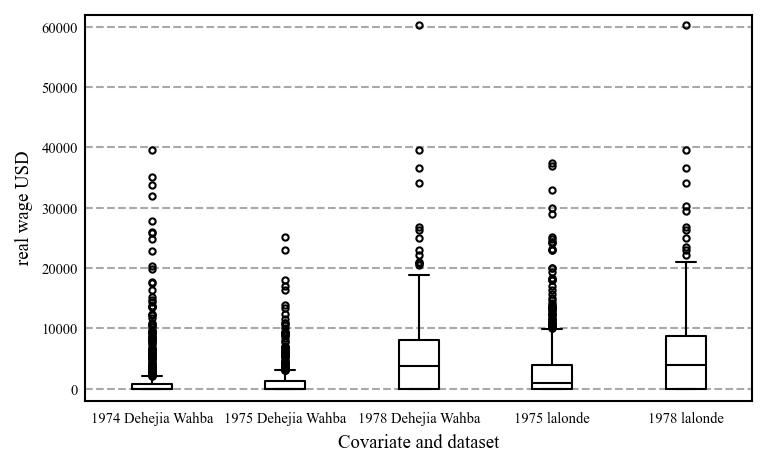

In [20]:
fig, ax = plt.subplots(figsize=(5, 3))

# Neat formatting for plots 
plt.rcParams.update({"figure.dpi": 150}) 
plt.rcParams.update(bundles.neurips2022())
plt.rcParams.update(fonts.neurips2022())
plt.rcParams.update(axes.tick_direction( y="in"))
plt.rcParams.update(axes.color(base="black"))
plt.rcParams.update(figsizes.neurips2022(nrows=1, ncols=4))
plt.rcParams.update(fontsizes.neurips2022())

ax.set_facecolor('white')
# Set boarder colour 
for spine in ax.spines:
    ax.spines[spine].set_color('black')
    ax.spines[spine].set_linewidth(1)

ax.grid(color='darkgrey', axis='y', linestyle='--', linewidth=1, alpha=1)
ax.grid(color='white', axis='x')

# Cusotmise median line 
medianprops = dict(linestyle='-', linewidth = 1, color='k')
boxprops = dict(linewidth = 1)
whiskerprops = dict(linewidth = 1)
capprops = dict(linewidth = 1)

flierprops = {'marker': 'o', 'markersize': 3,'linewidth':1}

wage74_dej = nswre74['re74']
wage75_dej = nswre74['re75']
wage78_dej = nswre74['re78']

wage75_lalonde = nsw['re75']
wage78_lalonde = nsw['re78']

ax.boxplot([wage74_dej,wage75_dej,wage78_dej,wage75_lalonde,wage78_lalonde],
            medianprops=medianprops,
            boxprops = boxprops,
            whiskerprops=whiskerprops,
            capprops = capprops ,
            flierprops = flierprops,
            widths=0.3) 

ax.set_xlim(0.5,5.5)
ax.set_ylim(-2000,62000)

plt.xticks([1,2,3,4,5],['1974 Dehejia Wahba', '1975 Dehejia Wahba','1978 Dehejia Wahba','1975 lalonde','1978 lalonde'])

ax.set_xlabel('Covariate and dataset')
ax.set_ylabel('real wage USD')



plt.savefig('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/plots/lalonde_notebook_plots/appendix plots/appendix1_wage_boxplots.png', bbox_inches='tight')
plt.show()

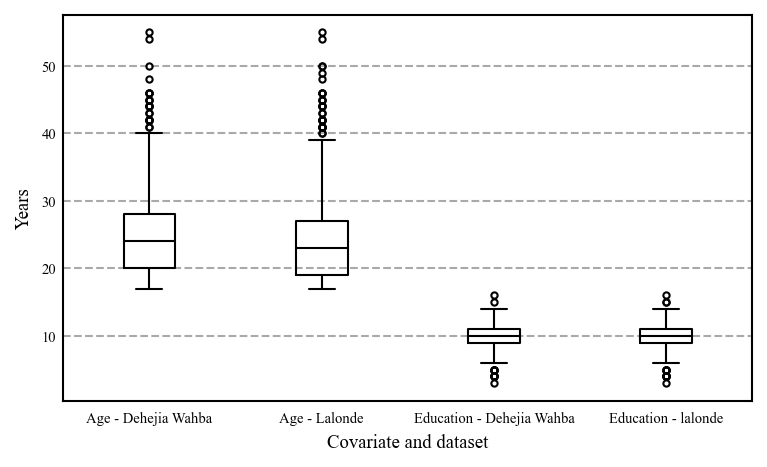

In [21]:
fig, ax = plt.subplots(figsize=(5, 3))
# Neat formatting for plots 
plt.rcParams.update({"figure.dpi": 150}) 
plt.rcParams.update(bundles.neurips2022())
plt.rcParams.update(fonts.neurips2022())
plt.rcParams.update(axes.tick_direction( y="in"))
plt.rcParams.update(axes.color(base="black"))
plt.rcParams.update(figsizes.neurips2022(nrows=1, ncols=4))
plt.rcParams.update(fontsizes.neurips2022())

ax.set_facecolor('white')
# Set boarder colour 
for spine in ax.spines:
    ax.spines[spine].set_color('black')
    ax.spines[spine].set_linewidth(1)

ax.grid(color='darkgrey', axis='y', linestyle='--', linewidth=1, alpha=1)
ax.grid(color='white', axis='x')

# Cusotmise median line 
medianprops = dict(linestyle='-', linewidth = 1, color='k')
boxprops = dict(linewidth = 1)
whiskerprops = dict(linewidth = 1)
capprops = dict(linewidth = 1)

flierprops = {'marker': 'o', 'markersize': 3,'linewidth':1}

Age_lalonde = nsw['age']
Educ_lalonde = nsw['education']

Age_dej = nswre74['age']
Educ_dej = nswre74['education']



ax.boxplot([Age_dej,Age_lalonde,Educ_dej,Educ_lalonde],
            medianprops=medianprops,
            boxprops = boxprops,
            whiskerprops=whiskerprops,
            capprops = capprops ,
            flierprops = flierprops,
            widths=0.3) 

#ax.set_xlim(0.5,5.5)
#ax.set_ylim(-2000,62000)

plt.xticks([1,2,3,4],['Age - Dehejia Wahba', 'Age - Lalonde','Education - Dehejia Wahba','Education - lalonde'])


ax.set_xlabel('Covariate and dataset')
ax.set_ylabel('Years')

plt.savefig('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/plots/lalonde_notebook_plots/appendix plots/appendix2_age_educ_boxplots.png', bbox_inches='tight')

plt.show()



<p> Outliers for CPS and PSID </p>

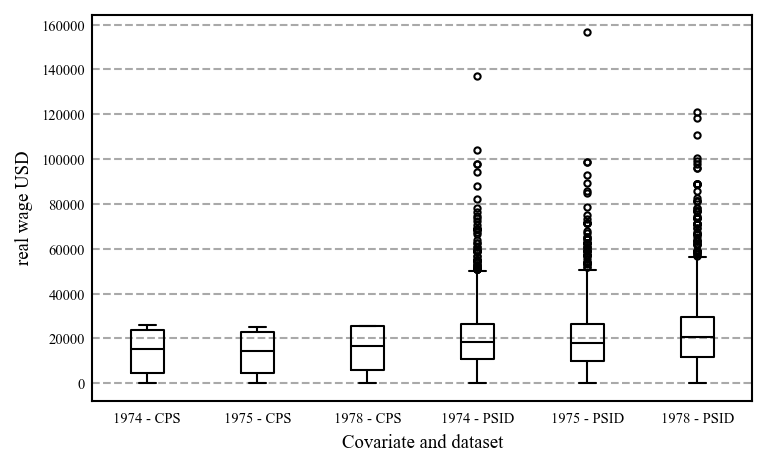

In [22]:
fig, ax = plt.subplots(figsize=(5, 3))

# Neat formatting for plots 
plt.rcParams.update({"figure.dpi": 150}) 
plt.rcParams.update(bundles.neurips2022())
plt.rcParams.update(fonts.neurips2022())
plt.rcParams.update(axes.tick_direction( y="in"))
plt.rcParams.update(axes.color(base="black"))
plt.rcParams.update(figsizes.neurips2022(nrows=1, ncols=4))
plt.rcParams.update(fontsizes.neurips2022())

ax.set_facecolor('white')
# Set boarder colour 
for spine in ax.spines:
    ax.spines[spine].set_color('black')
    ax.spines[spine].set_linewidth(1)

ax.grid(color='darkgrey', axis='y', linestyle='--', linewidth=1, alpha=1)
ax.grid(color='white', axis='x')

# Cusotmise median line 
medianprops = dict(linestyle='-', linewidth = 1, color='k')
boxprops = dict(linewidth = 1)
whiskerprops = dict(linewidth = 1)
capprops = dict(linewidth = 1)

flierprops = {'marker': 'o', 'markersize': 3,'linewidth':1}

wage74_cps = cps['re74']
wage75_cps = cps['re75']
wage78_cps = cps['re78']

wage74_psid = psid['re74']
wage75_psid = psid['re75']
wage78_psid = psid['re78']

ax.boxplot([wage74_cps,wage75_cps,wage78_cps,wage74_psid,wage75_psid,wage78_psid],
            medianprops=medianprops,
            boxprops = boxprops,
            whiskerprops=whiskerprops,
            capprops = capprops ,
            flierprops = flierprops,
            widths=0.3) 

#ax.set_xlim(0.5,5.5)
#ax.set_ylim(-2000,62000)

plt.xticks([1,2,3,4,5,6],['1974 - CPS', '1975 - CPS','1978 - CPS','1974 - PSID','1975 - PSID','1978 - PSID'])

ax.set_xlabel('Covariate and dataset')
ax.set_ylabel('real wage USD')


plt.savefig('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/plots/lalonde_notebook_plots/appendix plots/appendix3_wage_boxplots_cps_psid.png', bbox_inches='tight')
plt.show()

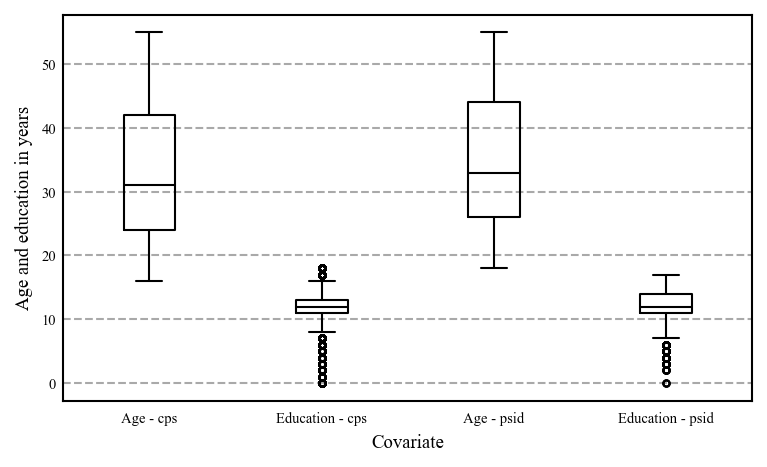

In [23]:
# Age and education 

fig, ax = plt.subplots(figsize=(5, 3))

# Neat formatting for plots 
plt.rcParams.update({"figure.dpi": 150}) 
plt.rcParams.update(bundles.neurips2022())
plt.rcParams.update(fonts.neurips2022())
plt.rcParams.update(axes.tick_direction( y="in"))
plt.rcParams.update(axes.color(base="black"))
plt.rcParams.update(figsizes.neurips2022(nrows=1, ncols=4))
plt.rcParams.update(fontsizes.neurips2022())

ax.set_facecolor('white')
# Set boarder colour 
for spine in ax.spines:
    ax.spines[spine].set_color('black')
    ax.spines[spine].set_linewidth(1)

ax.grid(color='darkgrey', axis='y', linestyle='--', linewidth=1, alpha=1)
ax.grid(color='white', axis='x')

# Cusotmise median line 
medianprops = dict(linestyle='-', linewidth = 1, color='k')
boxprops = dict(linewidth = 1)
whiskerprops = dict(linewidth = 1)
capprops = dict(linewidth = 1)

flierprops = {'marker': 'o', 'markersize': 3,'linewidth':1}


Age_cps = cps['age']
Educ_cps = cps['education']

Age_psid = psid['age']
Educ_psid = psid['education']

ax.boxplot([Age_cps,Educ_cps,Age_psid,Educ_psid],
            medianprops=medianprops,
            boxprops = boxprops,
            whiskerprops=whiskerprops,
            capprops = capprops ,
            flierprops = flierprops,
            widths=0.3) 

#ax.set_xlim(0.5,5.5)
#ax.set_ylim(-2000,62000)

plt.xticks([1,2,3,4],['Age - cps', 'Education - cps','Age - psid','Education - psid'])

ax.set_xlabel('Covariate')

ax.set_ylabel('Age and education in years')

plt.savefig('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/plots/lalonde_notebook_plots/appendix plots/appendix4_age_educ_cpspsid_boxplots.png', bbox_inches='tight')

plt.show()

### Remove outliers, transform variables and store dataset

In [24]:
# Drop outliers 
#cols = ['re75','re78','age','education'] 
#cols2 = ['re74','re75','re78','age','education'] 

#lower_bound = 0.5
#upper_bound = 0.95

#Q1_1 = nsw[cols].quantile(lower_bound)
#Q3_1 = nsw[cols].quantile(upper_bound)
#IQR_1 = Q3_1 - Q1_1

#Q1_2 = nswre74[cols2].quantile(lower_bound)
#Q3_2 = nswre74[cols2].quantile(upper_bound)
#IQR_2 = Q3_2 - Q1_2

#Q1_3 = cps[cols2].quantile(lower_bound)
#Q3_3 = cps[cols2].quantile(upper_bound)
#IQR_3 = Q3_3 - Q1_3

#Q1_4 = psid[cols2].quantile(lower_bound)
#Q3_4 = psid[cols2].quantile(upper_bound)
#IQR_4 = Q3_4 - Q1_4

#nsw = nsw[~((nsw[cols] < (Q1_1 -  IQR_1)) |(nsw[cols] > (Q3_1 +  IQR_1))).any(axis=1)]

#nswre74 = nswre74[~((nswre74[cols2] < (Q1_2 -  IQR_2)) |(nswre74[cols2] > (Q3_2 +  IQR_2))).any(axis=1)]

#cps = cps[~((cps[cols] < (Q1_3 - IQR_3)) |(cps[cols2] > (Q3_3 +  IQR_3))).any(axis=1)]
#psid = psid[~((psid[cols2] < (Q1_4 - IQR_4)) |(psid[cols2] > (Q3_4 + IQR_4))).any(axis=1)]

### Key points 
<p> 1. Taking logs of wage reveals that the distribution is bimodal </p>
<p> ---- There are a group of low wage earners (0 mode) and higher wave earns (around 8 mode) </p>
<p> ---- Treatment decreases amount of low wage earns, increases amount of high wave earners</p>

In [25]:
# Define function for feature transformation 
def feature_tranform(dataset):
    # account for integer overflow - convert features will tranform to 64bit type integer

    dataset['re75'] = dataset['re75'].astype(int)
    dataset['re78'] = dataset['re78'].astype(int)
    dataset['age'] = dataset['age'].astype(int)
    dataset['education'] = dataset['education'].astype(int) 

    #warnings.filterwarnings('ignore')

    if 're74' in dataset.columns: 
        dataset['re74'] = dataset['re74'].astype(int)  
        warnings.filterwarnings('ignore')
    else:
        pass

    # Keep a copy of education as numerical 
    dataset['education*'] = dataset['education']

    # Generate dummy variables 
    dataset['u75'] = (dataset['re75'] == 0).astype(int)
    # Generate interaction terms 
    dataset['educ_re75'] = dataset['education']*dataset['re75']
    dataset['hisp_u75'] = dataset['hispanic']*dataset['u75']
    dataset['black_u75'] = dataset['black']*dataset['u75']
    dataset['married_u75'] = dataset['married']*dataset['u75'] # married * unemployed 1975
    dataset['married_u75'] = dataset['married']*dataset['u75'] # married * wage 1975
    dataset['nodegree_re75'] = dataset['nodegree']*dataset['re75']# nodegree * wage 1975
    dataset['nodegree_u75'] = dataset['nodegree']*dataset['u75']# nodegree * unemployed 1975
    dataset['nodegree_education'] = dataset['nodegree']*dataset['education']
    dataset['black_age'] = dataset['black']*dataset['age']
    dataset['black_education'] = dataset['black']*dataset['education']
    dataset['hisp_re75'] = dataset['hispanic']*dataset['u75']
    
    if 're74' in dataset.columns: 
        dataset['u74'] = (dataset['re74'] == 0).astype(int)
        dataset['educ_re74'] = dataset['education']*dataset['re74']
        dataset['hisp_u74'] = dataset['hispanic']*dataset['u74']
        dataset['black_u74'] = dataset['black']*dataset['u74']
        dataset['married_u74'] = dataset['married']*dataset['u74']
        dataset['married_re74'] = dataset['married']*dataset['re74']
        dataset['nodegree_u75'] = dataset['nodegree']*dataset['u74']
        dataset['nodegree_u74'] = dataset['nodegree']*dataset['u74']
        dataset['nodegree_re74'] = dataset['nodegree']*dataset['re74']
        dataset['nodegree_re75'] = dataset['nodegree']*dataset['re75']
    else:
        pass    

    # Change zeroes to in wage as logs struggle
    #dataset['re78'][dataset['re78'] == 0] = 1
    #dataset['re75'][dataset['re75'] == 0] = 1

    #if 're74' in dataset.columns:
    #    dataset['re74'][dataset['re74'] == 0] = 1
    #else:
    #    pass     
        
    # squared variables
    dataset['agesq'] = dataset['age']*dataset['age']
    #dataset['re78sq'] = dataset['re78']*dataset['re78']
    #dataset['re75sq'] = dataset['re75']*dataset['re75']
    dataset['educsq'] = dataset['education']*dataset['education']

    #if 're74' in dataset.columns:
    #    dataset['re74sq'] = dataset['re74']*dataset['re74']
    #else:
    #    pass      

    # boxcox transforms of varibles
    dataset['ageboxcox'],parameters=stat.boxcox(dataset['age']) 
    #dataset['re78boxcox'],parameters=stat.boxcox(dataset['re78'])
    #dataset['re75boxcox'],parameters=stat.boxcox(dataset['re75'])

    #if 're74' in dataset.columns:
    #    dataset['re74boxcox'],parameters=stat.boxcox(dataset['re74'])
    #else:
    #    pass     
    # natural log of wage
    dataset['lnre78'] = np.log(dataset['re78'])
    dataset['lnre75'] = np.log(dataset['re75'])

    if 're74' in dataset.columns:
        dataset['lnre74'] = np.log(dataset['re74'])
    else:
        pass 

        # Change zeroes to in wage as logs struggle
    #dataset['re78'][dataset['re78'] == 1] = 0
    #dataset['re75'][dataset['re75'] == 1] = 0

    #if 're74' in dataset.columns:
    #    dataset['re74'][dataset['re74'] == 1] = 0
    #else:
    #    pass    

    # encode education as binary indicator variable 
    dataset = pd.get_dummies(dataset, columns=["education"],drop_first=True)
    
    return dataset  

In [26]:
# Combine lalonde treated units with cps and psid groups
Quasi_NswCps_lalonde_ = pd.concat([nsw[nsw['treat']==1],cps.drop(['re74'],axis=1)],ignore_index=True)
Quasi_NswPsid_lalonde_ = pd.concat([nsw[nsw['treat']==1],psid.drop(['re74'],axis=1)],ignore_index=True)
Quasi_NswCps_dehWab_ = pd.concat([nswre74[nswre74['treat']==1],cps],ignore_index=True)
Quasi_NswPsid_dehWab_ = pd.concat([nswre74[nswre74['treat']==1],psid], ignore_index=True)


In [27]:
# Pass data sets through feature transformation function 
nsw_transformed = feature_tranform(nsw)
nswre74_transformed = feature_tranform(nswre74)
Quasi_NswCps_lalonde = feature_tranform(Quasi_NswCps_lalonde_)
Quasi_NswPsid_lalonde = feature_tranform(Quasi_NswPsid_lalonde_)
Quasi_NswCps_dehWab = feature_tranform(Quasi_NswCps_dehWab_)
Quasi_NswPsid_dehWab = feature_tranform(Quasi_NswPsid_dehWab_)

/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [28]:
nsw_transformed.describe()

,treat,age,black,hispanic,married,nodegree,re75,re78,education*,u75,...,education_7,education_8,education_9,education_10,education_11,education_12,education_13,education_14,education_15,education_16
count,722.000000,722.000000,722.000000,722.000000,722.000000,722.000000,722.000000,722.000000,722.000000,722.000000,...,722.000000,722.000000,722.000000,722.000000,722.000000,722.000000,722.000000,722.000000,722.000000,722.000000
mean,0.411357,24.520776,0.800554,0.105263,0.162050,0.779778,3042.592798,5454.259003,10.267313,0.400277,...,0.020776,0.085873,0.152355,0.224377,0.270083,0.168975,0.031856,0.015235,0.002770,0.001385
std,0.492421,6.625947,0.399861,0.307105,0.368752,0.414683,5066.021008,6252.821190,1.704774,0.490294,...,0.142731,0.280370,0.359613,0.417460,0.444310,0.374990,0.175738,0.122573,0.052595,0.037216
min,0.000000,17.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,19.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,9.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,23.000000,1.000000,0.000000,0.000000,1.000000,936.000000,3951.500000,10.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,27.000000,1.000000,0.000000,0.000000,1.000000,3993.000000,8771.500000,11.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,55.000000,1.000000,1.000000,1.000000,1.000000,37431.000000,60307.000000,16.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [29]:
nswre74_transformed.describe()

,treat,age,black,hispanic,married,nodegree,re74,re75,re78,education*,...,education_7,education_8,education_9,education_10,education_11,education_12,education_13,education_14,education_15,education_16
count,445.000000,445.000000,445.000000,445.00000,445.000000,445.000000,445.000000,445.000000,445.000000,445.000000,...,445.000000,445.00000,445.000000,445.000000,445.000000,445.000000,445.000000,445.00000,445.000000,445.000000
mean,0.415730,25.370787,0.833708,0.08764,0.168539,0.782022,2102.128090,1376.955056,5300.404494,10.195506,...,0.020225,0.08764,0.152809,0.229213,0.256180,0.168539,0.029213,0.01573,0.002247,0.002247
std,0.493402,7.100282,0.372762,0.28309,0.374766,0.413337,5363.417594,3150.807175,6631.361546,1.792119,...,0.140927,0.28309,0.360208,0.420800,0.437014,0.374766,0.168594,0.12457,0.047405,0.047405
min,0.000000,17.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,0.000000,20.000000,1.000000,0.00000,0.000000,1.000000,0.000000,0.000000,0.000000,9.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
50%,0.000000,24.000000,1.000000,0.00000,0.000000,1.000000,0.000000,0.000000,3701.000000,10.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
75%,1.000000,28.000000,1.000000,0.00000,0.000000,1.000000,824.000000,1220.000000,8124.000000,11.000000,...,0.000000,0.00000,0.000000,0.000000,1.000000,0.000000,0.000000,0.00000,0.000000,0.000000
max,1.000000,55.000000,1.000000,1.00000,1.000000,1.000000,39570.000000,25142.000000,60307.000000,16.000000,...,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000


In [30]:
Quasi_NswCps_lalonde.describe()

,treat,age,black,hispanic,married,nodegree,re75,re78,education*,u75,...,education_9,education_10,education_11,education_12,education_13,education_14,education_15,education_16,education_17,education_18
count,16289.000000,16289.000000,16289.000000,16289.000000,16289.000000,16289.000000,16289.000000,16289.000000,16289.000000,16289.000000,...,16289.000000,16289.000000,16289.000000,16289.000000,16289.000000,16289.000000,16289.000000,16289.000000,16289.000000,16289.000000
mean,0.018233,33.068451,0.086807,0.072442,0.701823,0.303763,13457.362699,14684.453803,11.997483,0.114126,...,0.053103,0.072564,0.069740,0.387562,0.066794,0.071398,0.029161,0.083983,0.020443,0.036896
std,0.133810,11.041216,0.281553,0.259226,0.457465,0.459920,9317.138239,9677.387330,2.863578,0.317974,...,0.224246,0.259428,0.254717,0.487209,0.249672,0.257496,0.168262,0.277371,0.141515,0.188512
min,0.000000,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,24.000000,0.000000,0.000000,0.000000,0.000000,4017.000000,5367.000000,11.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,31.000000,0.000000,0.000000,1.000000,0.000000,14284.000000,16136.000000,12.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,42.000000,0.000000,0.000000,1.000000,1.000000,22783.000000,25564.000000,13.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,55.000000,1.000000,1.000000,1.000000,1.000000,37431.000000,60307.000000,18.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [31]:
Quasi_NswPsid_lalonde.describe()

,treat,age,black,hispanic,married,nodegree,re75,re78,education*,u75,...,education_8,education_9,education_10,education_11,education_12,education_13,education_14,education_15,education_16,education_17
count,2787.000000,2787.000000,2787.000000,2787.000000,2787.000000,2787.000000,2787.000000,2787.000000,2787.000000,2787.000000,...,2787.000000,2787.000000,2787.000000,2787.000000,2787.000000,2787.000000,2787.000000,2787.000000,2787.000000,2787.000000
mean,0.106566,33.761033,0.309293,0.039110,0.791891,0.350556,17358.130965,19893.421600,11.931826,0.129171,...,0.062433,0.053104,0.078938,0.085755,0.327951,0.052386,0.067815,0.023681,0.101902,0.075709
std,0.308610,10.587496,0.462286,0.193889,0.406025,0.477230,13858.764660,15632.545188,3.021046,0.335449,...,0.241983,0.224280,0.269690,0.280053,0.469551,0.222844,0.251473,0.152082,0.302573,0.264579
min,0.000000,17.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,25.000000,0.000000,0.000000,1.000000,0.000000,6795.500000,8629.500000,10.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,31.000000,0.000000,0.000000,1.000000,0.000000,16112.000000,19210.000000,12.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,43.000000,1.000000,0.000000,1.000000,1.000000,25064.000000,28076.000000,14.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,55.000000,1.000000,1.000000,1.000000,1.000000,156653.000000,121173.000000,17.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [32]:
Quasi_NswCps_dehWab.describe()

,treat,age,black,hispanic,married,nodegree,re74,re75,re78,education*,...,education_9,education_10,education_11,education_12,education_13,education_14,education_15,education_16,education_17,education_18
count,16177.000000,16177.000000,16177.000000,16177.000000,16177.000000,16177.000000,16177.000000,16177.000000,16177.000000,16177.000000,...,16177.000000,16177.000000,16177.000000,16177.000000,16177.000000,16177.000000,16177.000000,16177.000000,16177.000000,16177.000000
mean,0.011436,33.140508,0.082339,0.071892,0.705755,0.300550,13880.070100,13511.766088,14749.009705,12.008283,...,0.052482,0.071459,0.068183,0.388885,0.067071,0.071892,0.029301,0.084565,0.020585,0.037152
std,0.106329,11.036508,0.274889,0.258317,0.455717,0.458511,9613.066198,9313.110634,9670.841435,2.868005,...,0.223004,0.257599,0.252068,0.487512,0.250152,0.258317,0.168654,0.278241,0.141994,0.189139
min,0.000000,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,24.000000,0.000000,0.000000,0.000000,0.000000,4075.000000,4103.000000,5492.000000,11.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,31.000000,0.000000,0.000000,1.000000,0.000000,14892.000000,14374.000000,16240.000000,12.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,42.000000,0.000000,0.000000,1.000000,1.000000,23491.000000,22830.000000,25564.000000,13.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,55.000000,1.000000,1.000000,1.000000,1.000000,35040.000000,25243.000000,60307.000000,18.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [33]:
Quasi_NswPsid_dehWab.describe()

,treat,age,black,hispanic,married,nodegree,re74,re75,re78,education*,...,education_8,education_9,education_10,education_11,education_12,education_13,education_14,education_15,education_16,education_17
count,2675.000000,2675.000000,2675.000000,2675.000000,2675.000000,2675.000000,2675.000000,2675.000000,2675.000000,2675.000000,...,2675.000000,2675.000000,2675.000000,2675.000000,2675.000000,2675.000000,2675.000000,2675.000000,2675.000000,2675.000000
mean,0.069159,34.225794,0.291589,0.034393,0.819439,0.333084,18229.575701,17850.456075,20501.917009,11.994393,...,0.062056,0.049346,0.072523,0.077009,0.333458,0.053458,0.070654,0.024299,0.106168,0.078879
std,0.253772,10.499842,0.454579,0.182269,0.384726,0.471404,13722.175528,13877.698078,15632.435118,3.053556,...,0.241302,0.216629,0.259401,0.266656,0.471537,0.224987,0.256294,0.154005,0.308110,0.269599
min,0.000000,17.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,25.000000,0.000000,0.000000,1.000000,0.000000,8816.000000,7604.500000,9243.000000,10.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,32.000000,0.000000,0.000000,1.000000,0.000000,17437.000000,17008.000000,19432.000000,12.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,43.500000,1.000000,0.000000,1.000000,1.000000,25470.000000,25583.000000,28815.000000,14.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,55.000000,1.000000,1.000000,1.000000,1.000000,137148.000000,156653.000000,121173.000000,17.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [34]:
nsw_transformed.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/unmatched data/NswLalonde_transformed.csv',header = True,index = False)
nswre74_transformed.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/unmatched data/NswDeWab_transformed.csv',header = True,index = False)
Quasi_NswCps_lalonde.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/unmatched data/Quasi_NswCps_lalonde.csv',header = True,index = False)
Quasi_NswPsid_lalonde.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/unmatched data/Quasi_NswPsid_lalonde.csv',header = True,index = False)
Quasi_NswCps_dehWab.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/unmatched data/Quasi_NswCps_dehWab.csv',header = True,index = False)
Quasi_NswPsid_dehWab.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/unmatched data/Quasi_NswPsid_dehWab.csv',header = True,index = False)

# Exploratory causal analysis

In [35]:
# Look at the correlations 
nsw = pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/unmatched data/NswLalonde_transformed.csv') # RCT
nswre74 = pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/unmatched data/NswDeWab_transformed.csv') # RCT 
nswCps_lalonde =  pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/unmatched data/Quasi_NswCps_lalonde.csv') # Quasi data 
nswPsid_lalonde = pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/unmatched data/Quasi_NswPsid_lalonde.csv') # Quasi data 
nswCps_dehWab =   pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/unmatched data/Quasi_NswCps_dehWab.csv') # Quasi data 
nswPsid_dehWab =  pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/unmatched data/Quasi_NswPsid_dehWab.csv') # Quasi data 

In [109]:
vars = ['treat','age','education*','black','hispanic','married','nodegree','re75','re78']
vars2 = ['treat','age','education*','black','hispanic','married','nodegree','re74','re75','re78']

In [110]:
# Correlation matrix
corr = nsw[vars].corr()
corr.style.background_gradient(cmap='coolwarm')

,treat,age,education*,black,hispanic,married,nodegree,re75,re78
treat,1.000000,0.013318,0.055527,0.001659,-0.029928,0.014293,-0.099127,0.003827,0.069793
age,0.013318,1.000000,0.024495,0.093177,-0.116267,0.225965,-0.120741,0.066267,0.025149
education*,0.055527,0.024495,1.000000,0.068147,-0.157138,0.039105,-0.648409,0.087297,0.077172
black,0.001659,0.093177,0.068147,1.000000,-0.687184,0.012559,0.035868,-0.083762,-0.103311
hispanic,-0.029928,-0.116267,-0.157138,-0.687184,1.000000,-0.003868,0.084261,0.004658,0.054797
married,0.014293,0.225965,0.039105,0.012559,-0.003868,1.000000,-0.011193,0.206003,0.038799
nodegree,-0.099127,-0.120741,-0.648409,0.035868,0.084261,-0.011193,1.000000,-0.080344,-0.084762
re75,0.003827,0.066267,0.087297,-0.083762,0.004658,0.206003,-0.080344,1.000000,0.154894
re78,0.069793,0.025149,0.077172,-0.103311,0.054797,0.038799,-0.084762,0.154894,1.000000


In [111]:
# Correlation matrix
corr = nswre74[vars2].corr()
corr.style.background_gradient(cmap='coolwarm')

,treat,age,education*,black,hispanic,married,nodegree,re74,re75,re78
treat,1.000000,0.052977,0.070890,0.021602,-0.084066,0.046531,-0.151012,-0.001057,0.041514,0.133501
age,0.052977,1.000000,0.022964,0.087171,-0.090157,0.210072,-0.112838,-0.001226,0.052632,0.057166
education*,0.070890,0.022964,1.000000,0.045405,-0.144835,0.081613,-0.635575,0.041187,0.025843,0.116171
black,0.021602,0.087171,0.045405,1.000000,-0.693969,0.023731,0.041948,0.005448,-0.056390,-0.114952
hispanic,-0.084066,-0.090157,-0.144835,-0.693969,1.000000,0.009064,0.086638,-0.028488,0.040807,0.058601
married,0.046531,0.210072,0.081613,0.023731,0.009064,1.000000,-0.038554,0.142522,0.267918,0.032669
nodegree,-0.151012,-0.112838,-0.635575,0.041948,0.086638,-0.038554,1.000000,-0.067827,0.020793,-0.106064
re74,-0.001057,-0.001226,0.041187,0.005448,-0.028488,0.142522,-0.067827,1.000000,0.655192,0.085382
re75,0.041514,0.052632,0.025843,-0.056390,0.040807,0.267918,0.020793,0.655192,1.000000,0.084592
re78,0.133501,0.057166,0.116171,-0.114952,0.058601,0.032669,-0.106064,0.085382,0.084592,1.000000


In [112]:
# Correlation matrix
corr = nswCps_lalonde[vars].corr()
corr.style.background_gradient(cmap='coolwarm')

,treat,age,education*,black,hispanic,married,nodegree,re75,re78
treat,1.000000,-0.104203,-0.076956,0.345855,0.011479,-0.158924,0.126498,-0.151999,-0.122638
age,-0.104203,1.000000,-0.118666,-0.048005,-0.007009,0.446880,0.036953,0.357659,0.164283
education*,-0.076956,-0.118666,1.000000,-0.119812,-0.188410,0.010441,-0.727749,0.130995,0.142114
black,0.345855,-0.048005,-0.119812,1.000000,-0.086163,-0.106472,0.121605,-0.128708,-0.118535
hispanic,0.011479,-0.007009,-0.188410,-0.086163,1.000000,0.008723,0.145514,-0.040677,-0.042147
married,-0.158924,0.446880,0.010441,-0.106472,0.008723,1.000000,-0.086851,0.407141,0.264200
nodegree,0.126498,0.036953,-0.727749,0.121605,0.145514,-0.086851,1.000000,-0.190484,-0.164207
re75,-0.151999,0.357659,0.130995,-0.128708,-0.040677,0.407141,-0.190484,1.000000,0.669680
re78,-0.122638,0.164283,0.142114,-0.118535,-0.042147,0.264200,-0.164207,0.669680,1.000000


In [113]:
# Correlation matrix
corr = nswPsid_lalonde[vars].corr()
corr.style.background_gradient(cmap='coolwarm')

,treat,age,education*,black,hispanic,married,nodegree,re75,re78
treat,1.000000,-0.298031,-0.177382,0.367671,0.098281,-0.530475,0.275111,-0.356235,-0.307530
age,-0.298031,1.000000,-0.160074,-0.137139,-0.031814,0.322581,0.124423,0.251670,0.141225
education*,-0.177382,-0.160074,1.000000,-0.341885,-0.098393,0.076216,-0.755948,0.354661,0.378962
black,0.367671,-0.137139,-0.341885,1.000000,-0.135004,-0.288009,0.333238,-0.312593,-0.291159
hispanic,0.098281,-0.031814,-0.098393,-0.135004,1.000000,-0.028797,0.084523,-0.066192,-0.033950
married,-0.530475,0.322581,0.076216,-0.288009,-0.028797,1.000000,-0.149447,0.302857,0.265306
nodegree,0.275111,0.124423,-0.755948,0.333238,0.084523,-0.149447,1.000000,-0.307883,-0.315286
re75,-0.356235,0.251670,0.354661,-0.312593,-0.066192,0.302857,-0.307883,1.000000,0.748115
re78,-0.307530,0.141225,0.378962,-0.291159,-0.033950,0.265306,-0.315286,0.748115,1.000000


In [114]:
# Correlation matrix
corr = nswCps_dehWab[vars2].corr()
corr.style.background_gradient(cmap='coolwarm')

,treat,age,education*,black,hispanic,married,nodegree,re74,re75,re78
treat,1.000000,-0.071381,-0.062343,0.297728,-0.005177,-0.121921,0.095606,-0.131857,-0.138359,-0.093428
age,-0.071381,1.000000,-0.122818,-0.034175,-0.004346,0.442760,0.044051,0.410752,0.354579,0.159455
education*,-0.062343,-0.122818,1.000000,-0.114957,-0.188219,0.005980,-0.727836,0.100537,0.128297,0.139399
black,0.297728,-0.034175,-0.114957,1.000000,-0.083369,-0.089847,0.109214,-0.110302,-0.118299,-0.106253
hispanic,-0.005177,-0.004346,-0.188219,-0.083369,1.000000,0.011662,0.144297,-0.045515,-0.039281,-0.040641
married,-0.121921,0.442760,0.005980,-0.089847,0.011662,1.000000,-0.079107,0.429159,0.404028,0.258646
nodegree,0.095606,0.044051,-0.727836,0.109214,0.144297,-0.079107,1.000000,-0.174052,-0.185874,-0.159370
re74,-0.131857,0.410752,0.100537,-0.110302,-0.045515,0.429159,-0.174052,1.000000,0.871926,0.640331
re75,-0.138359,0.354579,0.128297,-0.118299,-0.039281,0.404028,-0.185874,0.871926,1.000000,0.669190
re78,-0.093428,0.159455,0.139399,-0.106253,-0.040641,0.258646,-0.159370,0.640331,0.669190,1.000000


In [115]:
# Correlation matrix
corr = nswPsid_dehWab[vars2].corr()
corr.style.background_gradient(cmap='coolwarm')

,treat,age,education*,black,hispanic,married,nodegree,re74,re75,re78
treat,1.000000,-0.218353,-0.147176,0.330845,0.037493,-0.446611,0.216887,-0.320546,-0.320578,-0.246828
age,-0.218353,1.000000,-0.188289,-0.103903,-0.000542,0.271627,0.173536,0.249709,0.223590,0.106229
education*,-0.147176,-0.188289,1.000000,-0.340172,-0.089019,0.047524,-0.757837,0.330487,0.346001,0.371068
black,0.330845,-0.103903,-0.340172,1.000000,-0.121081,-0.252673,0.321449,-0.288038,-0.294659,-0.270076
hispanic,0.037493,-0.000542,-0.089019,-0.121081,1.000000,0.013928,0.062485,-0.027239,-0.050218,-0.013022
married,-0.446611,0.271627,0.047524,-0.252673,0.013928,1.000000,-0.099225,0.279899,0.267600,0.221404
nodegree,0.216887,0.173536,-0.757837,0.321449,0.062485,-0.099225,1.000000,-0.277953,-0.289053,-0.297436
re74,-0.320546,0.249709,0.330487,-0.288038,-0.027239,0.279899,-0.277953,1.000000,0.855860,0.703784
re75,-0.320578,0.223590,0.346001,-0.294659,-0.050218,0.267600,-0.289053,0.855860,1.000000,0.743506
re78,-0.246828,0.106229,0.371068,-0.270076,-0.013022,0.221404,-0.297436,0.703784,0.743506,1.000000


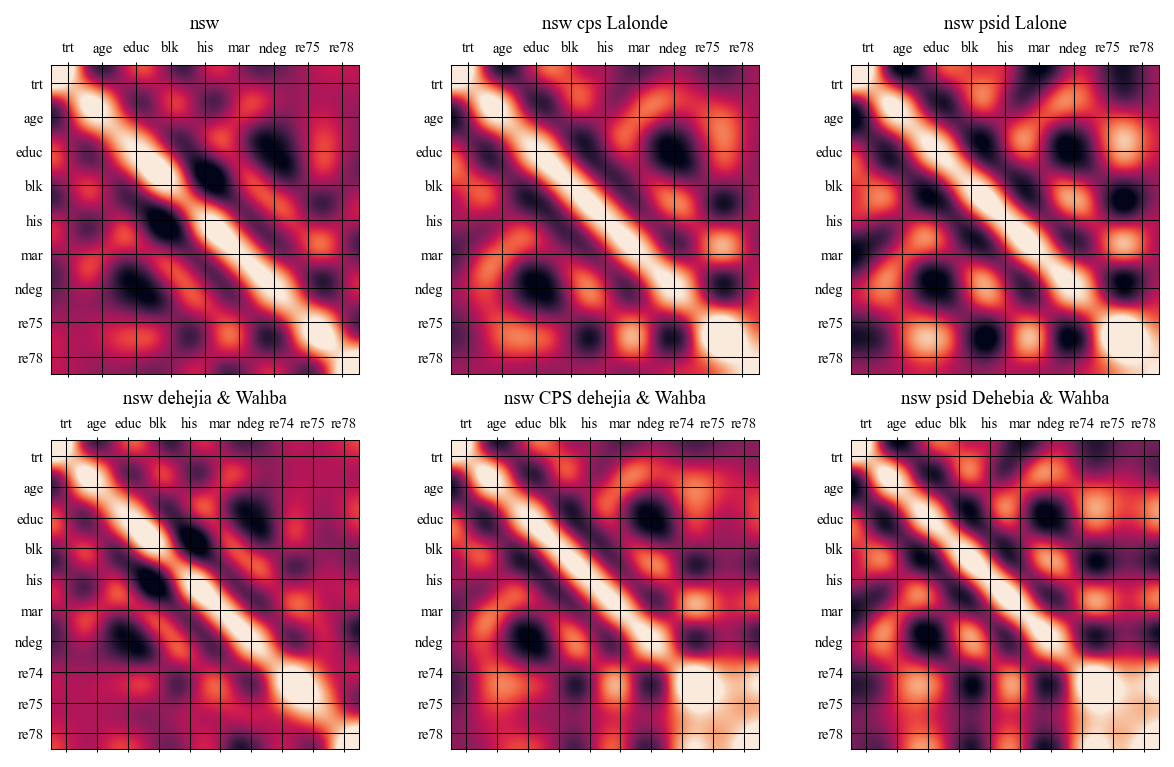

In [129]:
fig, ax = plt.subplots(nrows=2, ncols=3,figsize = (8,5))

plt.rcParams.update({"figure.dpi": 150}) 
plt.rcParams.update(bundles.neurips2022())
plt.rcParams.update(fonts.neurips2022())
plt.rcParams.update(axes.tick_direction( y="in"))
plt.rcParams.update(axes.color(base="black"))
plt.rcParams.update(axes.lines())

methods = [None, 'none', 'nearest', 'bilinear', 'bicubic', 'spline16',
           'spline36', 'hanning', 'hamming', 'hermite', 'kaiser', 'quadric',
           'catrom', 'gaussian', 'bessel', 'mitchell', 'sinc', 'lanczos']


interpol = methods[16]

tick_labels1 = ['trt','age','educ','blk','his','mar','ndeg','re75','re78']
tick_labels2 = ['trt','age','educ','blk','his','mar','ndeg','re74','re75','re78']

xaxis1 = np.arange(len(tick_labels1))
xaxis2 = np.arange(len(tick_labels2))
# ~~~~~~

ax[0,0].matshow(nsw[vars].corr(),interpolation=interpol)
ax[0,0].set_xticks(xaxis1)
ax[0,0].set_yticks(xaxis1)
ax[0,0].set_xticklabels(tick_labels1)
ax[0,0].set_yticklabels(tick_labels1)
ax[0,0].set_title("nsw")


# ~~~~~~
ax[0,1].matshow(nswCps_lalonde[vars].corr(),interpolation=interpol)
ax[0,1].set_xticks(xaxis1)
ax[0,1].set_yticks(xaxis1)
ax[0,1].set_xticklabels(tick_labels1)
ax[0,1].set_yticklabels(tick_labels1)
ax[0,1].set_title("nsw cps Lalonde")

# ~~~~~~
ax[0,2].matshow(nswPsid_lalonde[vars].corr(),interpolation=interpol)
ax[0,2].set_xticks(xaxis1)
ax[0,2].set_yticks(xaxis1)
ax[0,2].set_xticklabels(tick_labels1)
ax[0,2].set_yticklabels(tick_labels1)
ax[0,2].set_title("nsw psid Lalone")
# ~~~~~~
ax[1,0].matshow(nswre74[vars2].corr(),interpolation=interpol)
ax[1,0].set_xticks(xaxis2)
ax[1,0].set_yticks(xaxis2)
ax[1,0].set_xticklabels(tick_labels2)
ax[1,0].set_yticklabels(tick_labels2)
ax[1,0].set_title("nsw dehejia & Wahba")
# ~~~~~~
ax[1,1].matshow(nswCps_dehWab[vars2].corr(),interpolation=interpol)
ax[1,1].set_xticks(xaxis2)
ax[1,1].set_yticks(xaxis2)
ax[1,1].set_xticklabels(tick_labels2)
ax[1,1].set_yticklabels(tick_labels2)
ax[1,1].set_title("nsw CPS dehejia & Wahba")
# ~~~~~~
ax[1,2].matshow(nswPsid_dehWab[vars2].corr(),interpolation=interpol)
ax[1,2].set_xticks(xaxis2)
ax[1,2].set_yticks(xaxis2)
ax[1,2].set_xticklabels(tick_labels2)
ax[1,2].set_yticklabels(tick_labels2)
ax[1,2].set_title("nsw psid Dehebia & Wahba")


plt.savefig('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/plots/lalonde_notebook_plots/causal_disc_heatmap.png', bbox_inches='tight')

plt.show()


In [ ]:
import networkx as nx
import cdt 
from cdt import SETTINGS
from cdt.independence.graph import FSGNN
from cdt.causality.pairwise import GNN
from cdt.utils.graph import dagify_min_edge
from cdt.causality.graph import CGNN

### Save datasets

# Class imbalance plots for QuasiExperimental datasets 

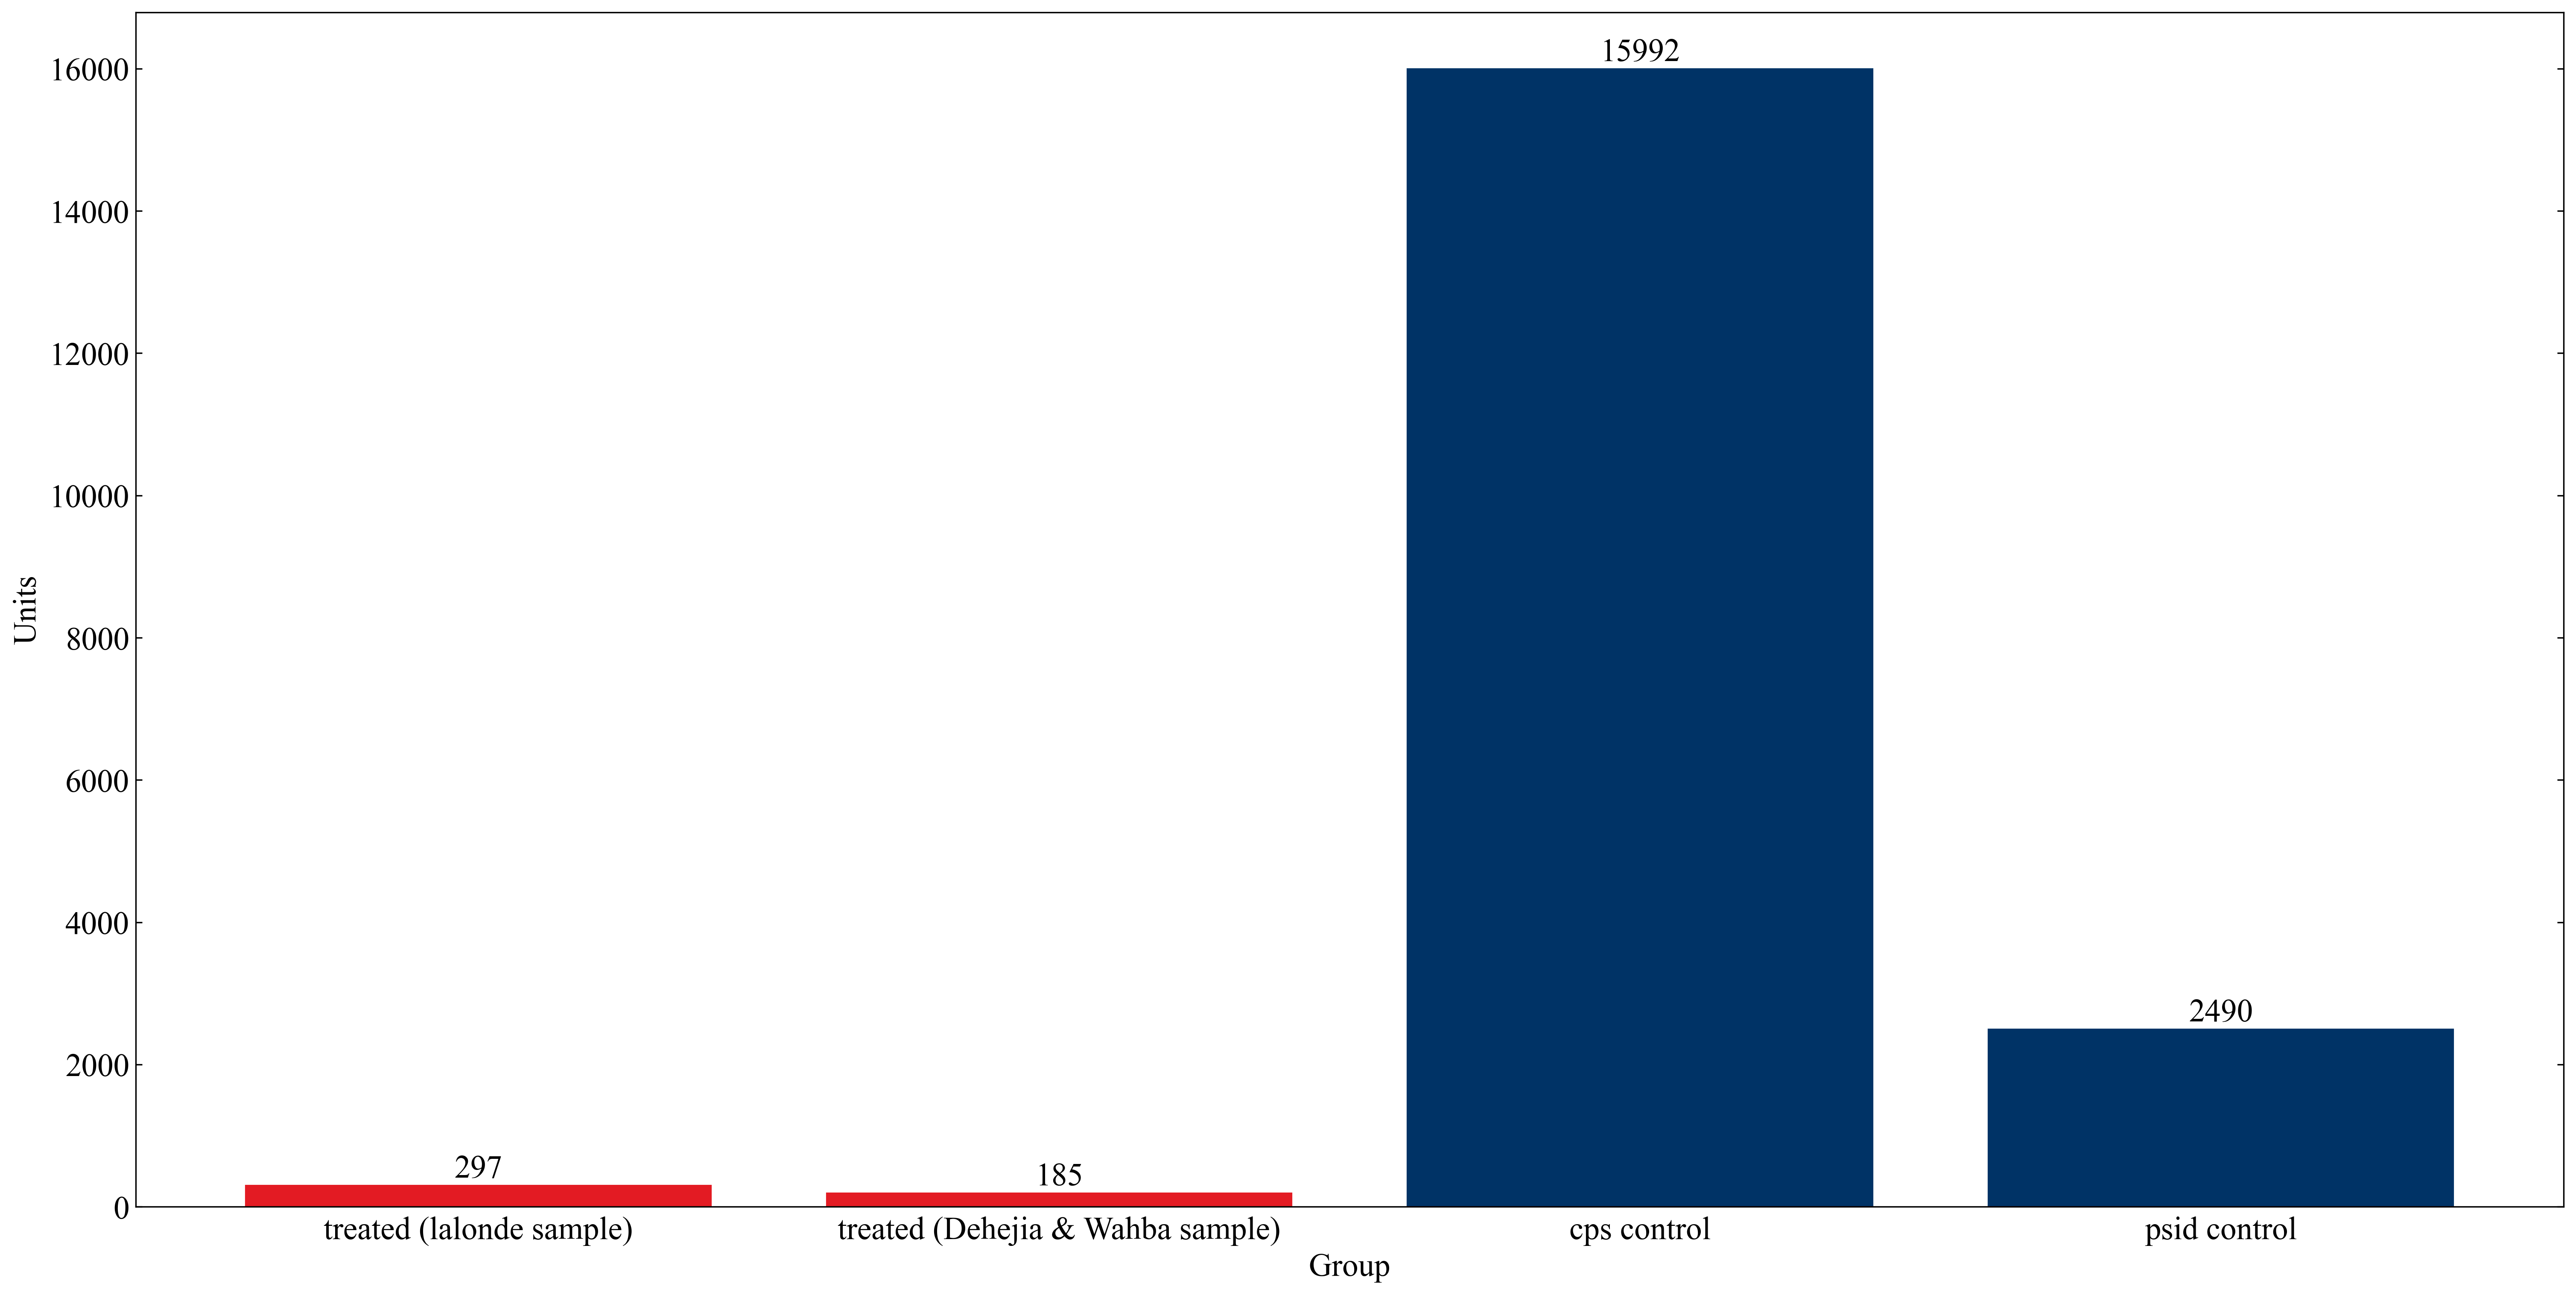

In [58]:
# Plot the balance of classes in the datasets 

# Lalonde sample 
lalondeTreated = Quasi_NswCps_lalonde[Quasi_NswCps_lalonde['treat']==1] # Treated lalonde 
dehWabTreated = Quasi_NswCps_dehWab[Quasi_NswCps_dehWab['treat']==1] # Treated dehWab


cpsControl = Quasi_NswCps_lalonde[Quasi_NswCps_lalonde['treat']==0] # Cps control
psidControl = Quasi_NswPsid_lalonde[Quasi_NswPsid_lalonde['treat']==0] # Psid control

nsw_heights = [len(lalondeTreated),len(dehWabTreated),len(cpsControl),len(psidControl)]

# Update plot paramaters 
fig, ax = plt.subplots(nrows=1, ncols=1,figsize = (20,10))


# Neat formatting for plots 
plt.rcParams.update({"figure.dpi": 300}) 
plt.rcParams.update(bundles.neurips2022())
plt.rcParams.update(fonts.neurips2022())
plt.rcParams.update(axes.tick_direction( y="in"))
plt.rcParams.update(axes.color(base="black"))
plt.rcParams.update(figsizes.neurips2022(nrows=1, ncols=1))
#plt.rcParams.update(fontsizes.neurips2022())
plt.rcParams.update({'font.size': 18})
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
plt.xlabel('xlabel', fontsize=18)
plt.ylabel('ylabel', fontsize=18)
# ==== ==== ==== ==== ==== ==== ==== ==== ==== # 
# Lalonde sample  bar plot 

# Lalonde sample
ax.set_facecolor('white')
ax.grid(color='white', axis='y')
ax.grid(color='white', axis='x')
#ax[0].set_ylim(0,700)

ax.spines['left']
ax.spines['bottom']
ax.spines['top']

ax.tick_params(right='on')
ax.tick_params(left='on')
#ax.tick_params(top='on')

ax.set_xlabel("Group")
ax.set_ylabel("Units")

bar = ax.bar(['treated (lalonde sample)','treated (Dehejia & Wahba sample)','cps control','psid control'],nsw_heights,width = 0.8)
# colour chart 
bar[0].set_color('#E31B23')
bar[1].set_color('#E31B23')
bar[2].set_color('#003366')
bar[3].set_color('#003366')

# Add counts to bar chart - lalonde sample 
for rect in ax.patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2
    space = 1
    label = "{:.0f}".format(y_value)
    ax.annotate(label, (x_value, y_value), xytext=(0, space), textcoords="offset points", ha='center', va='bottom')

# Save and display 
plt.savefig('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/plots/lalonde_notebook_plots/fig1_Quasi_data_classImbalance_bar_chart.png', bbox_inches='tight')
plt.show()

### Smote illustration

In [62]:
Quasi_NswCps_lalonde

,treat,age,black,hispanic,married,nodegree,re75,re78,education*,u75,...,education_9,education_10,education_11,education_12,education_13,education_14,education_15,education_16,education_17,education_18
0,1.0,37,1.0,0.0,1.0,1.0,0,9930,11,1,...,0,0,1,0,0,0,0,0,0,0
1,1.0,22,0.0,1.0,0.0,1.0,0,3595,9,1,...,1,0,0,0,0,0,0,0,0,0
2,1.0,30,1.0,0.0,0.0,0.0,0,24909,12,1,...,0,0,0,1,0,0,0,0,0,0
3,1.0,27,1.0,0.0,0.0,1.0,0,7506,11,1,...,0,0,1,0,0,0,0,0,0,0
4,1.0,33,1.0,0.0,0.0,1.0,0,289,8,1,...,0,0,0,0,0,0,0,0,0,0
5,1.0,22,1.0,0.0,0.0,1.0,0,4056,9,1,...,1,0,0,0,0,0,0,0,0,0
6,1.0,23,1.0,0.0,0.0,0.0,0,0,12,1,...,0,0,0,1,0,0,0,0,0,0
7,1.0,32,1.0,0.0,0.0,1.0,0,8472,11,1,...,0,0,1,0,0,0,0,0,0,0
8,1.0,22,1.0,0.0,0.0,0.0,0,2164,16,1,...,0,0,0,0,0,0,0,1,0,0
9,1.0,33,0.0,0.0,1.0,0.0,0,12418,12,1,...,0,0,0,1,0,0,0,0,0,0


In [61]:
resample_demo =SMOTEENN(random_state=0)

#resample data
features, target = resample_demo.fit_resample(Quasi_NswCps_lalonde.drop('treat', axis=1), Quasi_NswCps_lalonde['treat'])	
Quasi_NswCps_lalonde_smote = pd.concat([features,target],axis=1)

color= ['#E31B23' if l == 1 else '#003366' for l in Quasi_NswCps_lalonde['treat']]
color2= ['#E31B23' if l == 1 else '#003366' for l in Quasi_NswCps_lalonde_smote['treat']]


# Update plot paramaters 
fig, ax = plt.subplots(nrows=1, ncols=2,figsize = (20,8))

# Neat formatting for plots 
plt.rcParams.update({"figure.dpi": 300}) 
plt.rcParams.update(bundles.neurips2022())
plt.rcParams.update(fonts.neurips2022())
plt.rcParams.update(axes.tick_direction( y="in"))
plt.rcParams.update(axes.color(base="black"))
plt.rcParams.update(figsizes.neurips2022(nrows=1, ncols=1))
#plt.rcParams.update(fontsizes.neurips2022())
plt.rcParams.update({'font.size': 18})

ax[0].set_facecolor('white')
ax[0].grid(color='white', axis='y')
ax[0].grid(color='white', axis='x')
ax[0].spines['left']
ax[0].spines['bottom']
ax[0].spines['top']
ax[0].tick_params(right='on')
ax[0].tick_params(left='on')
ax[0].set_ylim(-500,26000)


ax[0].scatter(Quasi_NswCps_lalonde['age'], Quasi_NswCps_lalonde['re78'],color=color,facecolors='white',s=35)

#ax[0].set_yticks(fontsize=18)
#ax[0].set_xticks(fontsize=18)
ax[0].tick_params(axis="x", labelsize=20)
ax[0].tick_params(axis="y", labelsize=20)

ax[0].set_xlabel('age', fontsize=20)
ax[0].set_ylabel('1978 wage', fontsize=20)
ax[0].set_title("Before smote-enn augmentation",fontsize=20)



ax[1].set_facecolor('white')
ax[1].grid(color='white', axis='y')
ax[1].grid(color='white', axis='x')
ax[1].spines['left']
ax[1].spines['bottom']
ax[1].spines['top']
ax[1].set_ylim(-500,26000)

ax[1].tick_params(right='on')
ax[1].tick_params(left='on')
ax[1].scatter(Quasi_NswCps_lalonde_smote['age'], Quasi_NswCps_lalonde_smote['re78'],color=color2, facecolors='white',s=35)
ax[1].tick_params(axis="x", labelsize=20)
ax[1].tick_params(axis="y", labelsize=20)
ax[1].set_xlabel('age', fontsize=20)
ax[1].set_ylabel('1978 wage', fontsize=18)
ax[1].set_title("After smote-enn augmentation",fontsize=20)

labels = ['treated','control']
fig.legend(labels, loc='lower center', bbox_to_anchor=(0.5,-0.1), ncol=len(labels),markerscale=3, bbox_transform=fig.transFigure,prop={'size': 18})
plt.savefig('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/Jupyter notebooks/plots/lalonde_notebook_plots/fig2_SMOTE-ENN_transform_chart.png', bbox_inches='tight')

plt.show()


AttributeError: 'NoneType' object has no attribute 'split'